In [1]:
from tensorflow.keras.utils import normalize
import keras
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff
from tifffile import imread, imwrite
from skimage.transform import resize
#/home/elaugh/Downloads/October/train/image/image_8.tif
#/home/elaugh/Downloads/final-final/another_reproduced.hdf5

In [2]:
import sys,os,os.path
os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

In [4]:
from unet_model import unet_model 
def get_model():
    return unet_model(256,256, 4)
model = get_model()

1e-06
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 592         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 256, 256, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 2320        dropout[0][0]                    
________________________________________________________________________________________

In [19]:
# model.load_weights('/home/elaugh/Downloads/final-final/another_reproduced.hdf5')
# export HDF5_USE_FILE_LOCKING='FALSE'
# model.load_weights('/home/gridsan/rravishankar/testcode/best_model_standars.hdf5')
model.load_weights('rotate.hdf5')
#model.load_model_weights_hdf5(model,'/home/gridsan/rravishankar/testcode/best_model_standars.hdf5', HDF5_USE_FILE_LOCKING=False)

In [6]:
#image_directory = '/content/drive/MyDrive/EMANet-master/image.tiff'
#mask_directory = '/content/drive/MyDrive/EMANet-master/mask.tiff'
image_directory='/home/gridsan/ealmahmoud/data/test/images/'
mask_directory='/home/gridsan/ealmahmoud/data/test/masks/'
images = os.listdir(image_directory)
masks = os.listdir(mask_directory)

In [7]:
SIZE = 256
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected

In [8]:
all_mask_patches = []
all_img_patches = []


for i, mask_name in enumerate(masks): #Remember enumerate method adds a counter and returns the enumerate object
    if (mask_name.split('.')[1] == 'tif'):
        print("Now preparing image and masks number: ", mask_name)
        
        temp_image=tiff.imread(image_directory+mask_name)
        #temp_image=cv2.imread(image_directory+mask_name, cv2.IMREAD_UNCHANGED)
        temp_mask=tiff.imread(mask_directory+mask_name)
        #temp_mask=cv2.imread(mask_directory+mask_name, cv2.IMREAD_UNCHANGED)

        patches_img = patchify(temp_image, (SIZE, SIZE,4), step=SIZE)  #Step=256 for 256 patches means no overlap
        patches_mask = patchify(temp_mask, (SIZE, SIZE,4), step=SIZE)  #Step=256 for 256 patches means no overlap
        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):
                single_patch_img = patches_img[i,j,:,:]
                single_patch_mask = patches_mask[i,j,:,:]

                #if (1 - (counts[0]/counts.sum())) > 0.25:  #At least 5% useful area with labels that are not 0
                if(True):
                    all_img_patches.append(single_patch_img)
                    all_mask_patches.append(single_patch_mask)

Now preparing image and masks number:  image_5.tif
Now preparing image and masks number:  image_13.tif
Now preparing image and masks number:  image_4.tif


In [9]:
masks = np.array(all_mask_patches)
masks = np.squeeze(masks)

In [10]:
images = np.array(all_img_patches)
images = np.squeeze(images)

In [23]:
#IOU
y_pred=model.predict(images)
y_pred_thresholded = y_pred > 0.1

intersection = np.logical_and(masks, y_pred_thresholded)
union = np.logical_or(masks, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

IoU socre is:  0.3748123554289867


In [163]:
#2, 7, 13
#large_image = tiff.imread('/home/elaugh/Downloads/October/train/image/image_8.tif')
# large_image = tiff.imread('/home/gridsan/rravishankar/testcode/Data/images/image.tif')
large_image = tiff.imread('/home/gridsan/rravishankar/solar_farm_data/raw_images/images/image4.tif')
# large_image = tiff.imread('/Users/rashmiravishankar/Desktop/solarfarmimagery/California Flats/m_3512014_ne_10_060_20200607/m_3512014_ne_10_060_20200607.tif')
#large_image_re = resize(large_image, (12288, 10496, 4))

In [86]:
print(large_image.shape)
patches_0 = patchify(large_image, (256, 256,4), step=256)  #Step=256 for 256 patches means no overlap
patches = np.squeeze(patches_0)
print(patches.shape)

(12370, 10490, 4)
(48, 40, 256, 256, 4)


In [ ]:
predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        single_patch = patches[i,j,:,:]
        #print(single_patch.shape)
        single_patch_norm = normalize(np.array(single_patch), axis=1)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        #print(single_patch_input.shape)

#Predict and threshold for values above 0.5 probability
        single_patch_prediction = (model.predict(single_patch_input))
        #single_patch_prediction = (model.predict(single_patch_input)).astype(np.uint8)
        #print(single_patch_prediction.shape)    
        predicted_patches.append(single_patch_prediction)

In [91]:
predicted_patches_array = np.array(predicted_patches)
print(predicted_patches_array.shape)
predicted_patches_reshaped=np.reshape(predicted_patches_array, [patches.shape[0], patches.shape[1], 256,256])
print(predicted_patches_reshaped.shape)
predicted_patches_reshaped_sq=np.squeeze(predicted_patches_reshaped)
print(predicted_patches_reshaped_sq.shape)
print(predicted_patches_reshaped_sq.max())
#thresholding
predicted_patches_reshaped_sq_th=predicted_patches_reshaped_sq>0.3
#predicted_patches_reshaped_sq_int=predicted_patches_reshaped_sq.astype(np.uint8)

(1920, 1, 256, 256, 1)
(48, 40, 256, 256)
(48, 40, 256, 256)
0.7734186


In [93]:
reconstructed_image = []
#reconstructed_image = unpatchify(predicted_patches_reshaped_sq,(12288, 10496))
reconstructed_image = unpatchify(predicted_patches_reshaped_sq,(256*patches.shape[0],256*patches.shape[1]))
reconstructed_image_binary = unpatchify(predicted_patches_reshaped_sq_th,(256*patches.shape[0],256*patches.shape[1]))

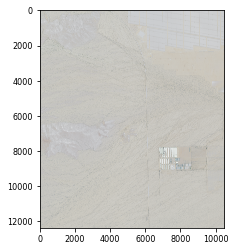

In [96]:
plt.imshow(large_image, cmap='gray', vmax=1, vmin=0)

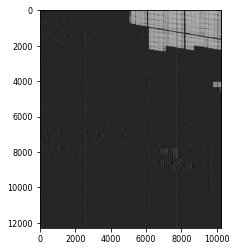

In [97]:
plt.imshow(reconstructed_image, cmap='gray', vmax=1, vmin=0)

In [165]:
large_image_cropped=[]
large_image_cropped=large_image[0:reconstructed_image_binary.shape[0],0:reconstructed_image_binary.shape[1],:]
#print(large_image_cropped.shape)
large_image_cropped[:,:,0]=large_image_cropped[:,:,0]
large_image_cropped[:,:,1]=large_image_cropped[:,:,1]+50*(reconstructed_image_binary)
large_image_cropped[:,:,2]=large_image_cropped[:,:,2]+100*(reconstructed_image_binary)
large_image_cropped[:,:,3]=large_image_cropped[:,:,3]


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x7f082f8d0fd0>)

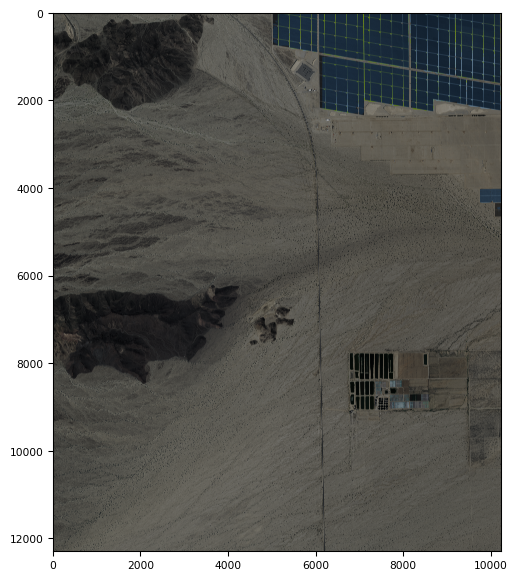

In [166]:
tiff.imshow(large_image_cropped)

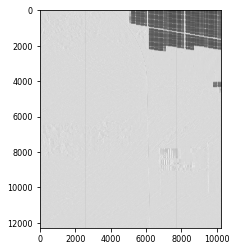

In [48]:
plt.imshow(1.0-reconstructed_image, cmap='gray', vmax=1, vmin=0)

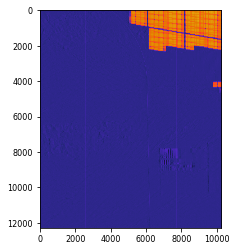

In [51]:
plt.imshow(reconstructed_image, cmap='CMRmap', vmax=1, vmin=0)

In [18]:
# plt.imshow(reconstructed_image, cmap='Pastel1', vmax=1, vmin=0)

In [19]:
plt.imsave('full_prediction_image4.jpg', reconstructed_image, cmap='gray', vmax=1, vmin=0)#, cmap='gray')

In [20]:
plt.imsave('full_prediction_image4_backup.jpg', reconstructed_image, cmap='gray', vmax=1, vmin=0)#, cmap='gray')

In [21]:
plt.imsave('full_prediction_image4_gist_ncar.jpg', reconstructed_image, cmap='gist_ncar', vmax=1, vmin=0)#, cmap='gray')

In [22]:
plt.imsave('full_prediction_image4_ocean.jpg', reconstructed_image, cmap='ocean', vmax=1, vmin=0)#, cmap='gray')

In [ ]:
plt.imsave('full_prediction_transparent_image4.jpg', reconstructed_image, cmap='ocean', vmax=1, vmin=0, alpha=0.95)#, cmap='gray')

## Accuracy 

In [23]:
# #Evaluate the model

# _, acc = model.evaluate(X_test, y_test)
# print("Accuracy = ", (acc * 100.0), "%")

## IOU

In [24]:
# #IOU
# y_pred=model.predict(X_test)
# y_pred_thresholded = y_pred > 0.1

# intersection = np.logical_and(y_test, y_pred_thresholded)
# union = np.logical_or(y_test, y_pred_thresholded)
# iou_score = np.sum(intersection) / np.sum(union)
# print("IoU socre is: ", iou_score)